#Multiclass Text Classification (Worker) with CNN Model

In [ ]:
!pip install nltk
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import string
import numpy as np
import pandas as pd
import csv
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Bidirectional, LSTM

##Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Loading the dataset
workers = pd.read_csv('/content/gdrive/MyDrive/data worker/dataset_worker.csv')

In [ ]:
# Looking at the first 5 rows of data
workers.head()

,text,label
0,"Selama bekerja di toko elektronik, saya berhas...",Service Kulkas
1,"Sebagai tim servis SoundSystem, saya telah ber...",Service Soundsystem
2,Saya memiliki pengalaman dalam pembuatan meja ...,Tukang Batu
3,"Dalam proyek-proyek renovasi, saya pernah berp...",Tukang Semen
4,Bertanggung jawab atas instalasi dan konfigura...,Service sistem


In [ ]:
# Counting the rows for each label
workers['label'].value_counts()

Service Kulkas             50
Service Soundsystem        50
Tukang Batu                50
Tukang Semen               50
Service sistem             50
Tukang Las                 50
Tukang Cat                 50
Service perangkat lunak    50
Service keamanan           50
Service AC                 50
Tukang Kayu                50
Service Mesin Cuci         50
Service Televisi           50
Service data               50
Service perangkat keras    50
Name: label, dtype: int64

In [ ]:
# Wordcount for each text row and counting the largest length
workers['word_length'] = workers['text'].str.split()
workers['word_length'] = workers['word_length'].str.len()

workers['word_length'].sort_values(ascending=False)

659    90
349    69
48     63
289    61
17     61
       ..
350     9
712     9
307     9
50      8
123     8
Name: word_length, Length: 750, dtype: int64

##Text Preprocessing


*   Remove punctuations and stopwords from the sentence
*   Lowercase the sentence
*   Tokenizing with TensorFlow's Tokenizer `fit_on_text`






In [ ]:
# Function to remove punctuation
def remove_punctuation(sentences):
  translator = str.maketrans('', '', string.punctuation)
  no_punct = sentences.translate(translator)

  return no_punct

In [ ]:
# Function to lowercase sentences and remove stopwords
def remove_stopword(sentences):
  # Lowercase and remove punctuation for sentences in each row
  sentences = sentences.lower()
  sentences = remove_punctuation(sentences)

  # Remove stopword
  factory = StopWordRemoverFactory()
  stopwords = factory.get_stop_words()

  words = sentences.split()
  words_result = [word for word in words if word not in stopwords]

  sentences = ' '.join(words_result)

  return sentences

In [ ]:
# Function to parse the csv data into an array of sentences and labels
def parse_data(filename):

  sentences = []
  labels = []

  with open (filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')

    next(reader, None)

    for row in reader:
      labels.append(remove_stopword(row[1]))
      sentences.append(remove_stopword(row[0]))

  return sentences, labels

In [ ]:
# Parsing the data and checking the row count

sentences, labels = parse_data("/content/gdrive/MyDrive/data worker/dataset_worker.csv")
print("ORIGINAL DATASET:\n")
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}\n\n")

ORIGINAL DATASET:

There are 750 sentences in the dataset.

First sentence has 38 words (after removing stopwords).

There are 750 labels in the dataset.

The first 5 labels are ['service kulkas', 'service soundsystem', 'tukang batu', 'tukang semen', 'service sistem']




In [ ]:
# Variables for tokenizing
vocab_size = 10000
embedding_dim = 16
max_length = 100
oov_token = "<OOV>"
trunc_type = 'post'
training_size = 0.9

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(sentences)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

In [ ]:
# Assuming label_tokenizer has been created and fit on labels

# Get the word-to-index mapping
word_index = label_tokenizer.word_index

# Invert the dictionary to get index-to-word mapping (classes)
#index_to_word = {index: word for word, index in word_index.items()}

# Create a list of classes in the correct order of indices
#classes = [index_to_word[i] for i in range(1, len(index_to_word) + 1)]  # Assuming indexing starts from 1

#print("Classes in the correct order:", classes)

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type, padding = 'post')

print('Shape of padded tensor:',padded.shape)

Shape of padded tensor: (750, 100)


In [ ]:
print(padded)

[[ 28  32  12 ...   0   0   0]
 [ 41   9  71 ...   0   0   0]
 [ 19  13  66 ...   0   0   0]
 ...
 [ 36 337 679 ...   0   0   0]
 [ 10   3  12 ...   0   0   0]
 [ 28 675  43 ...   0   0   0]]


In [ ]:
labels = pd.get_dummies(workers["label"]).values
print('Shape of label tensor:',labels.shape)

cek_label = pd.get_dummies(workers["label"])
encoding_to_class = {tuple(encoding): label for encoding, label in zip(cek_label.values, workers["label"])}
print(encoding_to_class)
#print(cek_label.head())

Shape of label tensor: (750, 15)
{(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service Kulkas', (0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service Soundsystem', (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 'Tukang Batu', (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 'Tukang Semen', (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 'Service sistem', (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 'Tukang Las', (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 'Tukang Cat', (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 'Service perangkat lunak', (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 'Service keamanan', (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service AC', (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 'Tukang Kayu', (0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service Mesin Cuci', (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service Televisi', (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0): 'Service data', (0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 'Service 

In [ ]:
print(labels)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##Splitting the Dataset with Sklearn's `train_test_split`

In [ ]:
random_seed = 42

train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(
    padded, labels, test_size=1-training_size, random_state=random_seed
)

In [ ]:
# Checking the sentences count for training and test
jml_train = len(train_sentences)
jml_test = len(validation_sentences)

print(f"There are {jml_train} sentences for training and {jml_test} for testing.")


There are 675 sentences for training and 75 for testing.


##CNN Model Architechture

In [ ]:
# CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(15, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 dropout_1 (Dropout)         (None, 100, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            5184      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
Total params: 166159 (649.06 KB)
Trainable params: 166159 (649.06 KB)
Non-trainable params: 0 (0.00 Byte)
______________

##Training the Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
          train_sentences,
          train_labels,
          validation_data = (validation_sentences, validation_labels),
          epochs = 400,
          verbose = 2
      )

Epoch 1/400
22/22 - 1s - loss: 2.7093 - accuracy: 0.0696 - val_loss: 2.7220 - val_accuracy: 0.0400 - 1s/epoch - 51ms/step
Epoch 2/400
22/22 - 0s - loss: 2.7079 - accuracy: 0.0696 - val_loss: 2.7208 - val_accuracy: 0.0400 - 230ms/epoch - 10ms/step
Epoch 3/400
22/22 - 0s - loss: 2.7066 - accuracy: 0.0696 - val_loss: 2.7198 - val_accuracy: 0.0400 - 199ms/epoch - 9ms/step
Epoch 4/400
22/22 - 0s - loss: 2.7059 - accuracy: 0.0696 - val_loss: 2.7186 - val_accuracy: 0.0400 - 220ms/epoch - 10ms/step
Epoch 5/400
22/22 - 0s - loss: 2.7054 - accuracy: 0.0696 - val_loss: 2.7177 - val_accuracy: 0.0400 - 207ms/epoch - 9ms/step
Epoch 6/400
22/22 - 0s - loss: 2.7033 - accuracy: 0.0696 - val_loss: 2.7166 - val_accuracy: 0.0400 - 204ms/epoch - 9ms/step
Epoch 7/400
22/22 - 0s - loss: 2.7027 - accuracy: 0.0696 - val_loss: 2.7157 - val_accuracy: 0.0400 - 214ms/epoch - 10ms/step
Epoch 8/400
22/22 - 0s - loss: 2.7023 - accuracy: 0.0696 - val_loss: 2.7145 - val_accuracy: 0.0400 - 226ms/epoch - 10ms/step
Epoch 

In [ ]:
# Rounding the testing labels
rounded_labels = np.argmax(validation_labels, axis=1)

In [ ]:
# Rounding the prediction labels
predictions = model.predict(validation_sentences)
predicted_labels = np.argmax(predictions, axis=1)

3/3 [==============================] - 0s 11ms/step


In [ ]:
# Checking the label class
unique_classes = np.unique(rounded_labels)
print("Unique Predicted Classes:", unique_classes)
print("Number of Unique Predicted Classes:", len(unique_classes))

unique_class = np.unique(predicted_labels)
print("Unique Predicted Classes:", unique_class)
print("Number of Unique Predicted Classes:", len(unique_class))

Unique Predicted Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of Unique Predicted Classes: 15
Unique Predicted Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of Unique Predicted Classes: 15


In [ ]:
model.save("model_worker.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Plotting the loss and accuracy

In [ ]:
import matplotlib.pyplot as plt

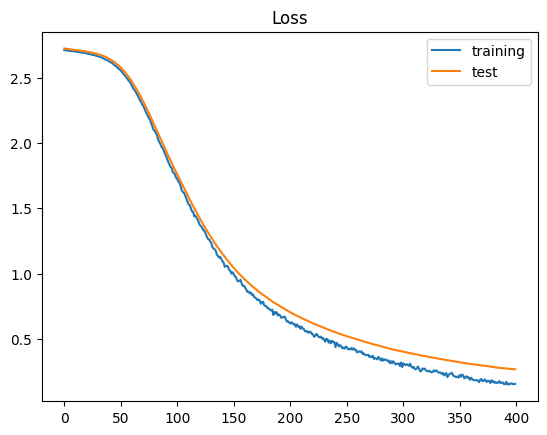

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

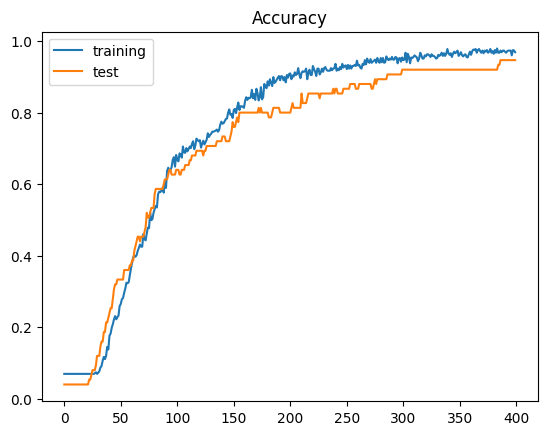

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

##Predicting a new sentence

In [ ]:
# Input new text (pengalaman)
pengalaman = 'saya telah bekerja sebagai pengukir selama beberapa tahun. saya memiliki banyak pengalaman bekerja membuat ukiran kayu untuk dipasang pada rumah tradisional bali.'

# Text preprocessing
pengalaman = pengalaman.lower()

translator = str.maketrans('', '', string.punctuation)
pengalaman = pengalaman.translate(translator)

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

kata = pengalaman.split()
hasil_kata = [word for word in kata if word not in stopwords]

pengalaman = ' '.join(hasil_kata)

pengalaman = [f'{pengalaman}']


sequence = tokenizer.texts_to_sequences(pengalaman)
padded_sequence = pad_sequences(sequence, maxlen=max_length)

# Performing inference (predicting the class)
predict = model.predict(padded_sequence)
predict_label = labels[np.argmax(predict)]
labels = ['service ac', 'service kulkas', 'service mesin cuci', 'service soundsystem', 'service televisi', 'service data', 'service keamanan', 'service perangkat keras', 'service perangkat lunak', 'service sistem', 'tukang batu', 'tukang cat', 'tukang kayu', 'tukang las', 'tukang semen']

# Print prediction result
print(predict)
print(predict_label)

1/1 [==============================] - 0s 21ms/step
[[3.8873517e-05 3.7597569e-05 1.7800962e-08 1.1612740e-06 2.5383651e-04
  2.2388942e-08 3.4596924e-05 1.7900526e-07 4.1800322e-07 1.7114171e-06
  6.3772663e-04 5.3301845e-03 9.9232376e-01 1.6414600e-04 1.1757105e-03]]
tukang kayu


##Plotting the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(rounded_labels, predicted_labels)

array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 5, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]])

In [ ]:
from sklearn.utils.multiclass import unique_labels
true_labels = unique_labels(rounded_labels)
pred_labels = unique_labels(predicted_labels)

In [ ]:
def plot(y_true, y_pred):
  labels = true_labels
  column = [f'Predicted{label}' for label in labels]
  indicies = [f'Actual{label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                       columns=column, index=indicies)

  return table

In [ ]:
plot(rounded_labels, predicted_labels)

,Predicted0,Predicted1,Predicted2,Predicted3,Predicted4,Predicted5,Predicted6,Predicted7,Predicted8,Predicted9,Predicted10,Predicted11,Predicted12,Predicted13,Predicted14
Actual0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Actual2,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0
Actual3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
Actual4,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0
Actual5,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0
Actual6,0,0,0,0,0,1,5,0,0,1,0,0,0,0,0
Actual7,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0
Actual8,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0
Actual9,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0
